In [83]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import optuna
import pickle
import plotly.express as px

from plotly.subplots import make_subplots
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error 
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.multioutput import MultiOutputRegressor
from sklearn.neighbors import KNeighborsRegressor

import sys
import os
from tqdm import tqdm

RAND = 10
N_FOLDS = 3

backend_path = os.path.abspath('../backend')
sys.path.append(backend_path)
model_path = os.path.abspath('../models')
sys.path.append(model_path)
from get_metrics import get_metrics_regression
from check_overfitting import check_overfitting

# Import data

In [84]:
# Чтение DataFrame df в файл data/df.csv
df = pd.read_csv('../data/df.csv')

In [85]:
df[:3]

,milliseconds,place,status,tsunami,significance,data_type,magnitude,country,longitude,latitude,depth,datetime,timezone,magnitude_bins,year,month,day,hour,minute,second
0,1668773163070,"14 km SSE of Eden Roc, Hawaii",automatic,0,58,earthquake,1.94,USA,-155.030334,19.374001,7.10,2022-11-18 12:06:03,+00:00,green,2022,11,18,12,6,3
1,1668773284487,"40 km ESE of Nikolski, Alaska",reviewed,0,62,earthquake,2.00,USA,-168.310800,52.786100,64.90,2022-11-18 12:08:04,+00:00,green,2022,11,18,12,8,4
2,1668773482790,"45 km SW of Howell, Utah",reviewed,0,21,earthquake,1.16,USA,-112.845833,41.512167,5.73,2022-11-18 12:11:22,+00:00,green,2022,11,18,12,11,22


In [86]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 94354 entries, 0 to 94353
Data columns (total 20 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   milliseconds    94354 non-null  int64  
 1   place           94354 non-null  object 
 2   status          94354 non-null  object 
 3   tsunami         94354 non-null  int64  
 4   significance    94354 non-null  int64  
 5   data_type       94354 non-null  object 
 6   magnitude       94354 non-null  float64
 7   country         94354 non-null  object 
 8   longitude       94354 non-null  float64
 9   latitude        94354 non-null  float64
 10  depth           94354 non-null  float64
 11  datetime        94354 non-null  object 
 12  timezone        94354 non-null  object 
 13  magnitude_bins  94354 non-null  object 
 14  year            94354 non-null  int64  
 15  month           94354 non-null  int64  
 16  day             94354 non-null  int64  
 17  hour            94354 non-null 

In [87]:
# основные описательные статистики для числовых признаков
df.iloc[:, 1:].describe()

,tsunami,significance,magnitude,longitude,latitude,depth,year,month,day,hour,minute,second
count,94354.000000,94354.000000,94354.000000,94354.000000,94354.000000,94354.000000,94354.000000,94354.000000,94354.000000,94354.000000,94354.000000,94354.000000
mean,0.000964,67.406363,1.720177,-116.542011,41.560005,26.813648,2022.824915,5.299479,15.482046,11.486010,29.419537,29.468290
std,0.031041,96.398645,1.178204,72.358151,20.357130,56.179701,0.380042,3.429028,8.635858,6.920763,17.357370,17.283395
min,0.000000,0.000000,0.000000,-179.998700,-65.425400,-3.740000,2022.000000,1.000000,1.000000,0.000000,0.000000,0.000000
25%,0.000000,14.000000,0.950000,-153.445775,34.018333,3.400000,2023.000000,3.000000,8.000000,6.000000,14.000000,15.000000
50%,0.000000,30.000000,1.400000,-122.852500,39.246300,9.200000,2023.000000,5.000000,16.000000,11.000000,29.000000,29.000000
75%,0.000000,68.000000,2.100000,-116.717375,58.264000,25.600000,2023.000000,7.000000,23.000000,17.000000,45.000000,44.000000
max,1.000000,2910.000000,7.800000,179.999400,86.593900,681.238000,2023.000000,12.000000,30.000000,23.000000,59.000000,59.000000


In [88]:
# основные описательные статистики для булевых и категориальных признаков
df.describe(include=["object", "bool"])

,place,status,data_type,country,datetime,timezone,magnitude_bins
count,94354,94354,94354,94354,94354,94354,94354
unique,34095,3,7,234,93284,1,3
top,"8km NW of The Geysers, CA",reviewed,earthquake,USA,2023-03-02 18:11:07,+00:00,green
freq,973,84325,92210,80057,2,94354,82184


# LabelEncoder

In [89]:
# создаем LabelEncoder для кодирования категориальных значений
le = LabelEncoder()

# список категориальных столбцов
categorical_cols = df.select_dtypes(include=[object]).columns

# кодируем каждый категориальный столбец
for col in categorical_cols:
    df[col] = le.fit_transform(df[col])

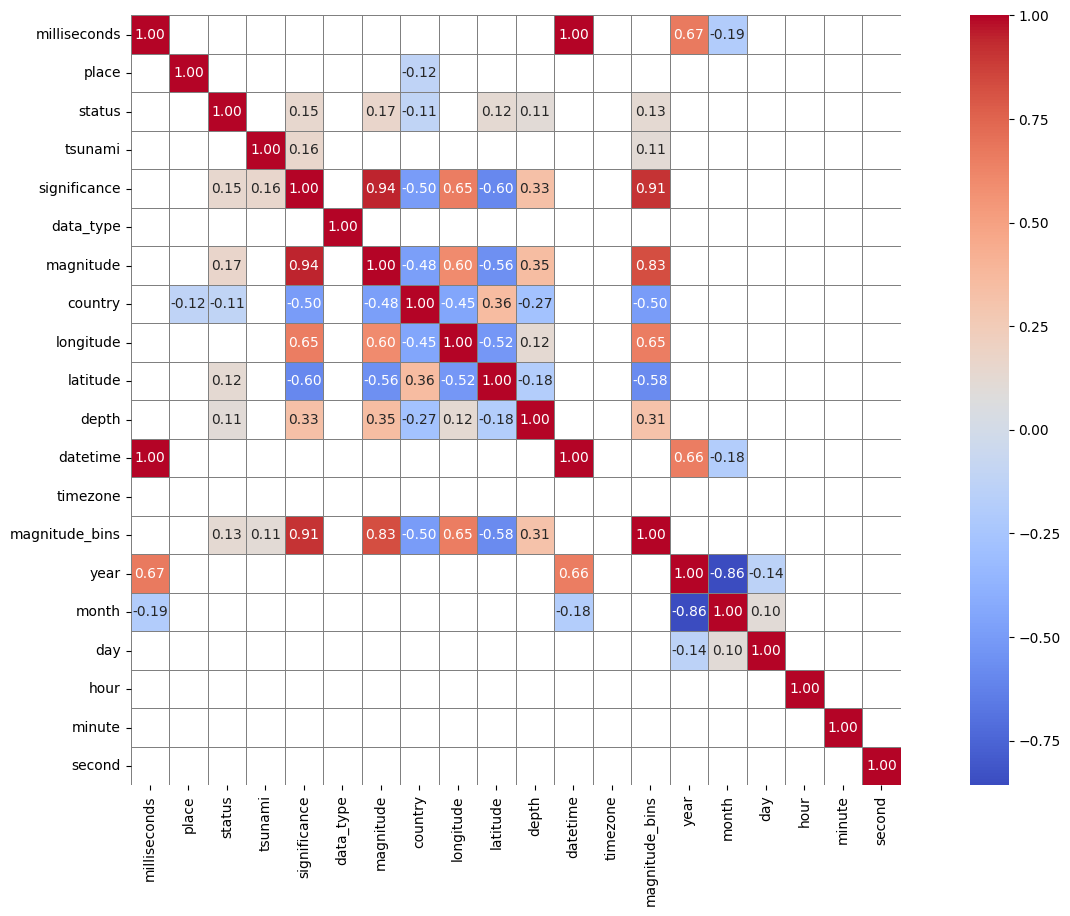

In [90]:
# рассчитываем матрицу корреляции
corr_matrix = df.corr()

# создаем маску
mask = np.abs(corr_matrix) < 0.1

# указывает размер графика
plt.figure(figsize=(18, 10))

# создаем тепловую карту матрицы корреляции
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', square=True, fmt='.2f', mask=mask, linewidths=0.5, linecolor='grey')

# Показываем график
plt.show()

In [91]:
df.columns

Index(['milliseconds', 'place', 'status', 'tsunami', 'significance',
       'data_type', 'magnitude', 'country', 'longitude', 'latitude', 'depth',
       'datetime', 'timezone', 'magnitude_bins', 'year', 'month', 'day',
       'hour', 'minute', 'second'],
      dtype='object')

# разделение данных train_test_split

In [93]:
# признаки
X = df[['status', 'significance', 'country', 'depth', 'magnitude_bins']]

# целевые переменные
y = df[['magnitude', 'longitude', 'latitude']]

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2,
                                                    random_state=RAND)

# Baseline 

## RandomForestRegressor

In [ ]:
# модель RandomForestRegressor
rfr = RandomForestRegressor(random_state=RAND)
# обучаем модель
rfr.fit(X_train, y_train)
#  предсказания на тестовой выборке
y_pred_rfr = rfr.predict(X_test)

In [ ]:
# проверка на переобучение модели RandomForestRegressor
check_overfitting(rfr, X_train, y_train, X_test, y_test, mean_squared_error)

In [ ]:
# просмотр метрик модели RandomForestRegressor обученной на train
metrics = get_metrics_regression(y_test,
                                 y_pred = y_pred_rfr,
                                 X_test = X_test,
                                 name='RandomForestRegressor_Baseline')
metrics

## DecisionTreeRegressor

In [ ]:
# модель DecisionTreeRegressor
dtr = DecisionTreeRegressor(random_state=RAND)
# обучаем модель
dtr.fit(X_train, y_train)
#  предсказания на тестовой выборке
y_pred_dtr = dtr.predict(X_test)

In [ ]:
# проверка на переобучение модели DecisionTreeRegressor
check_overfitting(dtr, X_train, y_train, X_test, y_test, mean_squared_error)

In [ ]:
# просмотр метрик модели DecisionTreeRegressor обученной на train
metrics = pd.concat([
    metrics,
    get_metrics_regression(y_test,
                           y_pred = y_pred_dtr,
                           X_test = X_test,
                           name='DecisionTreeRegressor_Baseline')])
metrics

## GradientBoostingRegressor

In [ ]:
# модель GradientBoostingRegressor
gbr = MultiOutputRegressor(GradientBoostingRegressor(random_state=RAND))

# обучаем модель
gbr.fit(X_train, y_train)
#  предсказания на тестовой выборке
y_pred_gbr = gbr.predict(X_test)


In [ ]:
# проверка на переобучение модели GradientBoostingRegressor
check_overfitting(gbr, X_train, y_train, X_test, y_test, mean_squared_error)

In [ ]:
# просмотр метрик модели GradientBoostingRegressor обученной на train
metrics = pd.concat([
    metrics,
    get_metrics_regression(y_test,
                           y_pred = y_pred_gbr,
                           X_test = X_test,
                           name='GradientBoostingRegressor_Baseline')])
metrics

## KNeighborsRegressor

In [ ]:
# модель KNeighborsRegressor
knn = KNeighborsRegressor()
# обучаем модель
knn.fit(X_train, y_train)
#  предсказания на тестовой выборке
y_pred_knn = knn.predict(X_test)

In [ ]:
# проверка на переобучение модели KNeighborsRegressor
check_overfitting(knn, X_train, y_train, X_test, y_test, mean_squared_error)

In [ ]:
# просмотр метрик модели KNeighborsRegressor обученной на train
metrics = pd.concat([
    metrics,
    get_metrics_regression(y_test,
                           y_pred = y_pred_knn,
                           X_test = X_test,
                           name='KNeighborsRegressor')])
metrics

# Optuna & KFold подбор гиперпараметров и кросс-валидация

## RandomForestRegressor

In [ ]:
# целевая функция для оптимизации
def objective(trial):
    # гиперпараметры для настройки
    n_estimators = trial.suggest_int('n_estimators', 100, 1000)
    max_depth = trial.suggest_int('max_depth', 5, 10)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 10)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 3)
    min_weight_fraction_leaf = trial.suggest_float('min_weight_fraction_leaf', 0.0, 0.5)
    max_features = trial.suggest_int('max_features', 1, 10)
    bootstrap = trial.suggest_categorical('bootstrap', [True, False])

    # RandomForestRegressor с гиперпараметрами
    rfr = RandomForestRegressor(n_estimators=n_estimators,
                                max_depth=max_depth,
                                min_samples_split=min_samples_split,
                                min_samples_leaf=min_samples_leaf,
                                min_weight_fraction_leaf=min_weight_fraction_leaf,
                                max_features=max_features,
                                bootstrap=bootstrap,
                                random_state=RAND)

    # выполнение кросс-валидации
    scores = cross_val_score(rfr, X_train, y_train, cv=KFold(n_splits=N_FOLDS, shuffle=True, random_state=RAND))
    score = np.mean(scores)

    return -score  # Optuna минимизирует целевую функцию, поэтому мы используем -score

# выполнение настройки гиперпараметров с Optuna
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=100, timeout=900)

In [ ]:
# получение лучших гиперпараметров
best_params_rfr = study.best_params

# создание RandomForestRegressor с лучшими гиперпараметрами
rfr_best_params = RandomForestRegressor(**best_params_rfr, random_state=RAND)

# обучение модели
rfr_best_params.fit(X_train, y_train)

# предсказания на тестовой выборке
y_pred_rfr_best_params = rfr_best_params.predict(X_test)

In [104]:
# оценка модели
check_overfitting(rfr_best_params, X_train, y_train, X_test, y_test, mean_squared_error)

# получение метрик
metrics = pd.concat([
    metrics,
    get_metrics_regression(y_test,
                           y_pred=y_pred_rfr_best_params,
                           X_test=X_test,
                           name='RandomForestRegressor_best_params_optuna')])
metrics

mean_squared_error train: 352.820
mean_squared_error test: 351.849
delta = 0.3 %


,model,MAE,MSE,RMSE,RMSLE,R2 adjusted
0,RandomForestRegressor_Baseline,5.869940,316.181355,17.781489,None,0.889282
0,DecisionTreeRegressor_Baseline,6.297846,466.331244,21.594704,None,0.844314
0,GradientBoostingRegressor_Baseline,9.352240,420.084720,20.495968,None,0.834799
0,KNeighborsRegressor,8.288183,565.746871,23.785434,None,0.805511
0,RandomForestRegressor_best_params_optuna,9.636140,486.651450,22.060178,None,0.784346
0,DecisionTreeRegressor_best_params_optuna,13.765290,908.206973,30.136472,None,0.610537
0,GradientBoostingRegressor_best_params_optuna,8.268731,369.515744,19.222792,None,0.857253
0,KNeighborsRegressor_best_params_optuna,7.656665,529.616349,23.013395,None,0.820817
0,RandomForestRegressor_best_params_optuna,9.636140,486.651450,22.060178,None,0.784346


## DecisionTreeRegressor

In [ ]:
# целевая функция для оптимизации
def objective(trial):
    # гиперпараметры для настройки
    splitter = trial.suggest_categorical('splitter', ['best', 'random'])
    max_depth = trial.suggest_int('max_depth', 5, 10)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 10)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 3)
    min_weight_fraction_leaf = trial.suggest_float('min_weight_fraction_leaf', 0.0, 0.5)
    max_features = trial.suggest_int('max_features', 1, 10)
    max_leaf_nodes = trial.suggest_int('max_leaf_nodes', 2, 5)

    # DecisionTreeRegressor с гиперпараметрами
    rfr = DecisionTreeRegressor(splitter=splitter,
                                max_depth=max_depth,
                                min_samples_split=min_samples_split,
                                min_samples_leaf=min_samples_leaf,
                                min_weight_fraction_leaf=min_weight_fraction_leaf,
                                max_features=max_features,
                                max_leaf_nodes=max_leaf_nodes,
                                random_state=RAND)

    # выполнение кросс-валидации
    scores = cross_val_score(rfr, X_train, y_train, cv=KFold(n_splits=N_FOLDS, shuffle=True, random_state=RAND))
    score = np.mean(scores)

    return -score  # Optuna минимизирует целевую функцию, поэтому мы используем -score

# выполнение настройки гиперпараметров с Optuna
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=100, timeout=900)

In [ ]:
# получение лучших гиперпараметров
best_params_dtr = study.best_params

# создание RandomForestRegressor с лучшими гиперпараметрами
dtr_best_params = DecisionTreeRegressor(**best_params_dtr, random_state=RAND)

# обучение модели
dtr_best_params.fit(X_train, y_train)

# предсказания на тестовой выборке
y_pred_dtr_best_params = dtr_best_params.predict(X_test)

In [ ]:
# оценка модели
check_overfitting(dtr_best_params, X_train, y_train, X_test, y_test, mean_squared_error)

# получение метрик
metrics = pd.concat([
    metrics,
    get_metrics_regression(y_test,
                           y_pred=y_pred_dtr_best_params,
                           X_test=X_test,
                           name='DecisionTreeRegressor_best_params_optuna')])
metrics

## GradientBoostingRegressor

In [ ]:
# целевая функция для оптимизации
def objective(trial):
    # гиперпараметры для настройки
    learning_rate = trial.suggest_float('estimator__learning_rate', 0, 1)
    n_estimators = trial.suggest_int('estimator__n_estimators', 100, 1000)
    subsample = trial.suggest_float('estimator__subsample', 0.1, 1.0)
    min_samples_split = trial.suggest_int('estimator__min_samples_split', 2, 10)
    min_samples_leaf = trial.suggest_int('estimator__min_samples_leaf', 1, 5)
    min_weight_fraction_leaf = trial.suggest_float('estimator__min_weight_fraction_leaf', 0.0, 0.5)
    max_depth = trial.suggest_int('estimator__max_depth', 1, 10)

    # GradientBoostingRegressor с гиперпараметрами
    gbr = MultiOutputRegressor(GradientBoostingRegressor(learning_rate=learning_rate,                                                    
                                                         n_estimators=n_estimators,
                                                         subsample=subsample,
                                                         min_samples_split=min_samples_split,
                                                         min_samples_leaf=min_samples_leaf,
                                                         min_weight_fraction_leaf=min_weight_fraction_leaf,
                                                         max_depth=max_depth,
                                                         random_state=RAND))

    # выполнение кросс-валидации
    scores = cross_val_score(gbr, X_train, y_train, cv=KFold(n_splits=N_FOLDS, shuffle=True, random_state=RAND))
    score = np.mean(scores)

    return -score  # Optuna минимизирует целевую функцию, поэтому мы используем -score

# выполнение настройки гиперпараметров с Optuna
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=100, timeout=900)

In [ ]:
# получение лучших гиперпараметров
best_params_gbr = study.best_params

# создание GradientBoostingRegressor с лучшими гиперпараметрами
gbr_best_params = MultiOutputRegressor(GradientBoostingRegressor(**{k.replace('estimator__', ''): v for k, v in best_params_gbr.items()}, random_state=RAND))

# обучение модели
gbr_best_params.fit(X_train, y_train)

# предсказания на тестовой выборке
y_pred_gbr_best_params = gbr_best_params.predict(X_test)

In [ ]:
# оценка модели
check_overfitting(gbr_best_params, X_train, y_train, X_test, y_test, mean_squared_error)

# получение метрик
metrics = pd.concat([
    metrics,
    get_metrics_regression(y_test,
                           y_pred=y_pred_gbr_best_params,
                           X_test=X_test,
                           name='GradientBoostingRegressor_best_params_optuna')])
metrics

## KNeighborsRegressor

In [ ]:
# целевая функция для оптимизации
def objective(trial):
    # гиперпараметры для настройки
    n_neighbors = trial.suggest_int('n_neighbors', 2, 10)
    weights = trial.suggest_categorical('weights', ['uniform', 'distance'])
    algorithm = trial.suggest_categorical('algorithm', ['brute', 'ball_tree', 'kd_tree'])
    leaf_size = trial.suggest_int('leaf_size', 10, 50)
    p = trial.suggest_int('p', 1, 5)
    metric = trial.suggest_categorical('metric', ['euclidean', 'manhattan', 'minkowski'])

    # KNeighborsRegressor с гиперпараметрами
    knn = KNeighborsRegressor(n_neighbors=n_neighbors,
                              weights=weights,
                              algorithm=algorithm,
                              leaf_size=leaf_size,
                              p=p,
                              metric=metric
                              )

    # выполнение кросс-валидации
    scores = cross_val_score(knn, X_train, y_train, cv=KFold(n_splits=N_FOLDS, shuffle=True, random_state=RAND))
    score = np.mean(scores)

    return -score  # Optuna минимизирует целевую функцию, поэтому мы используем -score

# выполнение настройки гиперпараметров с Optuna
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=100, timeout=900)

In [ ]:
# получение лучших гиперпараметров
best_params_knn = study.best_params

# создание RandomForestRegressor с лучшими гиперпараметрами
knn_best_params = KNeighborsRegressor(**best_params_knn)

# обучение модели
knn_best_params.fit(X_train, y_train)

# предсказания на тестовой выборке
y_pred_knn_best_params = knn_best_params.predict(X_test)

In [ ]:
# оценка модели
check_overfitting(knn_best_params, X_train, y_train, X_test, y_test, mean_squared_error)

# получение метрик
metrics = pd.concat([
    metrics,
    get_metrics_regression(y_test,
                           y_pred=y_pred_knn_best_params,
                           X_test=X_test,
                           name='KNeighborsRegressor_best_params_optuna_Baseline')])
metrics

# Сохранение моделей с лучшими параметрами и метриками

In [ ]:
# # сохраняем модель rfr_best_params
# model_file = os.path.join(model_path, 'rfr_best_params.pkl')
# with open(model_file, 'wb') as f:
#     pickle.dump(rfr_best_params, f)

# # сохраняем модель dtr_best_params
# model_file = os.path.join(model_path, 'dtr_best_params.pkl')
# with open(model_file, 'wb') as f:
#     pickle.dump(dtr_best_params, f)

# # сохраняем модель gbr_best_params
# model_file = os.path.join(model_path, 'gbr_best_params.pkl')
# with open(model_file, 'wb') as f:
#     pickle.dump(gbr_best_params, f)

# # сохраняем модель в knn_best_params
# model_file = os.path.join(model_path, 'knn_best_params.pkl')
# with open(model_file, 'wb') as f:
#     pickle.dump(knn_best_params, f)

# # сохранение metrics в файл data/metrics.csv
# metrics.to_csv('../data/metrics.csv', index=False)

# Загрузка моделей с лучшими параметрами

In [94]:
# # загружаем модель rfr_best_params
# with open(os.path.join(model_path, 'rfr_best_params.pkl'), 'rb') as f:
#     rfr_best_params = pickle.load(f)

# # загружаем модель dtr_best_params
# with open(os.path.join(model_path, 'dtr_best_params.pkl'), 'rb') as f:
#     dtr_best_params = pickle.load(f)

# # загружаем модель gbr_best_params
# with open(os.path.join(model_path, 'gbr_best_params.pkl'), 'rb') as f:
#     gbr_best_params = pickle.load(f)

# # загружаем модель knn_best_params
# with open(os.path.join(model_path, 'knn_best_params.pkl'), 'rb') as f:
#     knn_best_params = pickle.load(f)

# Функция выбора лучшей модели

In [105]:
metrics

,model,MAE,MSE,RMSE,RMSLE,R2 adjusted
0,RandomForestRegressor_Baseline,5.869940,316.181355,17.781489,None,0.889282
0,DecisionTreeRegressor_Baseline,6.297846,466.331244,21.594704,None,0.844314
0,GradientBoostingRegressor_Baseline,9.352240,420.084720,20.495968,None,0.834799
0,KNeighborsRegressor,8.288183,565.746871,23.785434,None,0.805511
0,RandomForestRegressor_best_params_optuna,9.636140,486.651450,22.060178,None,0.784346
0,DecisionTreeRegressor_best_params_optuna,13.765290,908.206973,30.136472,None,0.610537
0,GradientBoostingRegressor_best_params_optuna,8.268731,369.515744,19.222792,None,0.857253
0,KNeighborsRegressor_best_params_optuna,7.656665,529.616349,23.013395,None,0.820817
0,RandomForestRegressor_best_params_optuna,9.636140,486.651450,22.060178,None,0.784346


In [95]:
def select_best_model(X_test, y_test, rfr_best_params, dtr_best_params, gbr_best_params, knn_best_params):
    """
    Выбирает лучшую модель на основе средней квадратичной ошибки (MSE) на тестовой выборке.

    Параметры:
    - X_test: Тестовые признаки
    - y_test: Тестовая целевая переменная
    - rfr_best_params: Обученная модель случайного леса регрессии
    - dtr_best_params: Обученная модель дерева решений регрессии
    - gbr_best_params: Обученная модель градиентного бустинга регрессии
    - knn_best_params: Обученная модель k-ближайших соседей регрессии

    Возвращает:
    - Лучшую модель на основе MSE
    """
    models = [rfr_best_params, dtr_best_params, gbr_best_params, knn_best_params]
    mse_values = []

    for model in models:
        y_pred = model.predict(X_test)
        mse = mean_squared_error(y_test, y_pred)
        mse_values.append(mse)

    best_model_index = mse_values.index(min(mse_values))
    best_model = models[best_model_index]

    return best_model

In [96]:
best_model = select_best_model(X_test, y_test, rfr_best_params, dtr_best_params, gbr_best_params, knn_best_params)
print("Лучшая модель:", best_model)

Лучшая модель: MultiOutputRegressor(estimator=GradientBoostingRegressor(learning_rate=0.09488831505495321,
                                                         max_depth=9,
                                                         min_samples_leaf=4,
                                                         min_samples_split=8,
                                                         min_weight_fraction_leaf=0.0026303680222468217,
                                                         n_estimators=733,
                                                         random_state=10,
                                                         subsample=0.38904287748478733))


In [97]:
# предсказания на тестовой выборке лучшей модели
y_pred_best_model = best_model.predict(X_test)

In [98]:
df_y_pred_rfr_best_params = pd.DataFrame(y_pred_rfr_best_params, columns=['magnitude', 'longitude', 'latitude'])
df_y_pred_dtr_best_params = pd.DataFrame(y_pred_dtr_best_params, columns=['magnitude', 'longitude', 'latitude'])
df_y_pred_gbr_best_params = pd.DataFrame(y_pred_gbr_best_params, columns=['magnitude', 'longitude', 'latitude'])
df_y_pred_knn_best_params = pd.DataFrame(y_pred_knn_best_params, columns=['magnitude', 'longitude', 'latitude'])
df_y_pred_best_model = pd.DataFrame(y_pred_best_model, columns=['magnitude', 'longitude', 'latitude'])

## Сравнение карт лучшей модели и фактических данных

In [103]:
# создание карты с магнитудой лучшей модели
fig1 = px.scatter_geo(df_y_pred_best_model, lat='latitude', lon='longitude',
                     color='magnitude', color_continuous_scale='reds',
                     title='Earthquakes Around the World best vs fact')

fig1.update_layout(
    geo=dict(
        landcolor='white',
        oceancolor='lightblue',
        showland=True,
        showocean=True,
    ),
    width=600,  
    height=400,  
)

# создание карты с магнитудой реальными данными
fig2 = px.scatter_geo(y_test, lat='latitude', lon='longitude',
                     color='magnitude', color_continuous_scale='reds',
                     title='Earthquakes Around the World')

fig2.update_layout(
    geo=dict(
        landcolor='white',
        oceancolor='lightblue',
        showland=True,
        showocean=True,
    ),
    width=600,  
    height=400,  
)

# создаем subplot
fig = make_subplots(rows=1, cols=2, 
                    specs=[[{'type': 'geo'}, {'type': 'geo'}]], 
                    subplot_titles=['Earthquakes Around the World best model', 'Earthquakes Around the World fact'])

# добавляем карты в subplot
fig.add_trace(fig1.data[0], row=1, col=1)
fig.add_trace(fig2.data[0], row=1, col=2)

# обновляем layout
fig.update_layout(
    width=1200,  
    height=400,  
)

fig.show()

In [100]:
# # Обратное преобразование масштабированных данных в X_train
# X_train[['milliseconds', 'depth', 'year', 'month', 'day', 'hour', 'minute', 'second']] = scaler.inverse_transform(X_train[['milliseconds', 'depth', 'year', 'month', 'day', 'hour', 'minute', 'second']])

# # Обратное преобразование масштабированных данных в X_test
# X_test[['milliseconds', 'depth', 'year', 'month', 'day', 'hour', 'minute', 'second']] = scaler.inverse_transform(X_test[['milliseconds', 'depth', 'year', 'month', 'day', 'hour', 'minute', 'second']])

In [101]:
# декодирование колонки 'country'
#X_train['country'] = le.inverse_transform(X_train['country'])
#X_test['country'] = le.inverse_transform(X_test['country'])